In [ ]:
from sklearn.model_selection import GridSearchCV

In [39]:
# warnings get old after awhile
warnings.filterwarnings(action='ignore')

### Define functions

In [40]:
# A function that allows us to drop rows based on values we think are suspect

def drop_rows(df, colname, val):
    return df[df[colname] != val]

In [41]:
# A function to take columns with years (yr_built, yr_renovated) and bin them by decade

from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

In [42]:
# Contains all of our data cleaning operations

def clean():
    
# Load the data
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows
    # The row with 33 bedrooms is a suspicious outlier, so we decided to drop it
    # The 454 ?s in sqft_basement needed to be remedied. We chose to drop them. 

    clean_house = drop_rows(house, 'bedrooms', 33)
    clean_house = drop_rows(clean_house,'sqft_basement', "?")
    
# Bin decades
    
    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
    
# Get dummies
    # Note: Originally, we dropped waterfront because it had a lot of null values. Get dummies gives you the option to create a dummy for nulls or not.
    # We did that, without the null column
    clean_house = pd.get_dummies(clean_house, columns=(['waterfront', 'view', 'floors', 'bedrooms', 'bathrooms','condition', 'grade','zipcode', 'yr_built', 'yr_renovated']))
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date'], axis=1)
    
# Convert sqft_basement from object to float

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [46]:
clean_house = clean()
clean_house.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront_0.0,...,"yr_renovated_(1920, 1929]","yr_renovated_(1930, 1939]","yr_renovated_(1940, 1949]","yr_renovated_(1950, 1959]","yr_renovated_(1960, 1969]","yr_renovated_(1970, 1979]","yr_renovated_(1980, 1989]","yr_renovated_(1990, 1999]","yr_renovated_(2000, 2010]","yr_renovated_(2010, 2020]"
0,221900.0,1180,5650,1180,0.0,47.5112,-122.257,1340,5650,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,400.0,47.7210,-122.319,1690,7639,1,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,770,10000,770,0.0,47.7379,-122.233,2720,8062,1,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,47.5208,-122.393,1360,5000,1,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,47.6168,-122.045,1800,7503,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
filter_col = [col for col in clean_house if col.startswith('zipcode')]
house.groupby('zipcode')['price'].mean().sort_values(ascending=False)[:10]

zipcode
98039    2.161300e+06
98004    1.356524e+06
98040    1.194874e+06
98112    1.096239e+06
98102    8.996077e+05
98109    8.800778e+05
98105    8.632289e+05
98006    8.599386e+05
98119    8.497148e+05
98005    8.102897e+05
Name: price, dtype: float64

In [24]:
98039    2.161300e+06
98004    1.356524e+06
98040    1.194874e+06
98112    1.096239e+06
98102    8.996077e+05
98109    8.800778e+05
98105    8.632289e+05
98006    8.599386e+05

SyntaxError: invalid syntax (<ipython-input-24-4247c5b42aba>, line 1)

In [25]:
clean_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21142 entries, 0 to 21596
Columns: 172 entries, price to yr_renovated_(2010, 2020]
dtypes: float64(4), int64(5), uint8(163)
memory usage: 4.9 MB


### Feature selection

In [15]:
# copied function from Model Fit Linear Regression Lab

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [26]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

NameError: name 'stepwise_selection' is not defined

In [47]:
# We generated a list of features to use using a stepwise selection function from Flatiron's learn.co lessons
    # Finds the best p values from your features
    # Note: The resulting list contains 79 of the original 135 features

clean_house_selections_list = ['price', 'sqft_living', 'view_4.0', 'lat', 'zipcode_98004', 'zipcode_98039', 'zipcode_98112', 'zipcode_98040', 'view_0.0', 'grade_12', 'grade_13', 'grade_11', 'grade_10', 'waterfront_1.0', 'grade_9', 'zipcode_98105', 'zipcode_98119', 'condition_5', 'zipcode_98109', 'zipcode_98199', 'zipcode_98155', 'zipcode_98102', 'zipcode_98122', 'zipcode_98033', 'zipcode_98103', 'zipcode_98115', 'zipcode_98117', 'zipcode_98116', 'zipcode_98006', 'zipcode_98107', 'zipcode_98144', 'zipcode_98005', 'zipcode_98136', 'zipcode_98008', 'yr_renovated_(2000, 2010]', 'bathrooms_7.75', 'zipcode_98029', 'zipcode_98052', 'sqft_basement', 'sqft_above', 'condition_4', 'bathrooms_8.0', 'view_3.0', 'zipcode_98027', 'zipcode_98126', 'zipcode_98007', 'bathrooms_6.0', 'sqft_living15', 'zipcode_98118', 'bathrooms_4.75', 'yr_built_(2010, 2020]', 'zipcode_98019', 'sqft_lot', 'zipcode_98077', 'zipcode_98028', 'floors_3.0', 'grade_8', 'floors_2.0', 'bedrooms_3', 'bathrooms_4.25', 'zipcode_98011', 'bathrooms_3.25', 'yr_renovated_(2010, 2020]', 'zipcode_98014', 'zipcode_98072', 'zipcode_98133', 'zipcode_98022', 'zipcode_98178', 'bathrooms_3.75', 'bathrooms_4.5', 'bedrooms_7', 'bathrooms_4.0', 'bathrooms_5.5', 'bathrooms_5.25', 'bathrooms_5.0', 'bathrooms_6.25', 'yr_renovated_(1990, 1999]', 'zipcode_98010', 'yr_built_(1930, 1939]', 'zipcode_98075', 'zipcode_98038', 'bedrooms_6', 'floors_2.5', 'bathrooms_5.75', 'bedrooms_10', 'zipcode_98168', 'bedrooms_9', 'bedrooms_5', 'condition_1', 'yr_built_(1920, 1929]', 'zipcode_98074', 'zipcode_98053', 'sqft_lot15', 'zipcode_98106', 'bathrooms_2.25', 'zipcode_98198', 'zipcode_98058', 'bathrooms_1.0', 'bathrooms_3.0']
print("The number of features used in the model is:", len(clean_house_selections_list)-1)

# Made a new DF with just the features from our selections list
clean_house_selections = clean_house[clean_house_selections_list]


The number of features used in the model is: 98


### Model with Statsmodels OLS

In [49]:
# Used statsmodels OLS so we could get a handy summary of the regression results

y = clean_house["price"]
X = clean_house.drop(['price'], axis=1)

predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     706.3
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        18:27:28   Log-Likelihood:            -2.8130e+05
No. Observations:               21142   AIC:                         5.629e+05
Df Residuals:                   20980   BIC:                         5.642e+05
Df Model:                         161                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.166e+07   3.56e+06     -6.083      0.000   -2.86e+07   -1.47e+07
sqft_living                  88.7138      1.761     50.384      0.000      85.263      92.165
sqft_lot                      0.2521      0.036      7.067      0.000       0.182       0.322
sqft_above                   66.4054      1.873     35.455      0.000      62.734      70.076
sqft_basement                22.4268      2.064     10.863      0.000      18.380      26.473
lat                        2.225e+05   5.83e+04      3.816      0.000    1.08e+05    3.37e+05
long                      -2.016e+05   4.23e+04     -4.768      0.000   -2.84e+05   -1.19e+05
sqft_living15                23.4497      2.718      8.628      0.000      18.123      28.777
sqft_lot15                   -0.1520      0.056     -2.698      0.007      -0.262      -0.042
waterfront_0.0              596.9444   3209.731      0.186      0.852   -5694.376    6888.265
waterfront_1.0             6.066e+05   1.56e+04     38.998      0.000    5.76e+05    6.37e+05
view_0.0                  -4.801e+04   1.88e+04     -2.555      0.011   -8.48e+04   -1.12e+04
view_1.0                   4.254e+04   2.05e+04      2.079      0.038    2437.489    8.26e+04
view_2.0                   2.685e+04   1.94e+04      1.385      0.166   -1.11e+04    6.48e+04
view_3.0                   1.042e+05   1.99e+04      5.228      0.000    6.51e+04    1.43e+05
view_4.0                   2.455e+05   2.14e+04     11.485      0.000    2.04e+05    2.87e+05
floors_1.0                -3.598e+06   5.93e+05     -6.062      0.000   -4.76e+06   -2.43e+06
floors_1.5                -3.611e+06   5.93e+05     -6.086      0.000   -4.77e+06   -2.45e+06
floors_2.0                 -3.63e+06   5.93e+05     -6.117      0.000   -4.79e+06   -2.47e+06
floors_2.5                -3.559e+06   5.93e+05     -5.998      0.000   -4.72e+06    -2.4e+06
floors_3.0                -3.683e+06   5.94e+05     -6.206      0.000   -4.85e+06   -2.52e+06
floors_3.5                -3.576e+06   5.95e+05     -6.006      0.000   -4.74e+06   -2.41e+06
bedrooms_1                -1.898e+06   3.24e+05     -5.855      0.000   -2.53e+06   -1.26e+06
bedrooms_2                -1.891e+06   3.24e+05     -5.836      0.000   -2.53e+06   -1.26e+06
bedrooms_3                 -1.88e+06   3.24e+05     -5.801      0.000   -2.52e+06   -1.24e+06
bedrooms_4                -1.895e+06   3.24e+05     -5.848      0.000   -2.53e+06   -1.26e+06
bedrooms_5                -1.909e+06   3.24e+05     -5.892      0.000   -2.54e+06   -1.27e+06
bedrooms_6                -1.934e+06   3.24e+05     -5.968      0.000   -2.57e+06    -1.3e+06
bedrooms_7                -2.072e+06   3.25e+05     -6.382      0.000   -2.71e+06   -1.44e+06
bedrooms_8                -1.936e+06   3.26e+05     -5.932      0.000   -2.

### Improving the Model with Lasso

In [58]:
# We used standardization (Scikitlearn's Standard Scaler) to make sure we get the best results 
    # Takes each data point, subtracts the mean of the sample, then divides by the standard deviation of the sample

clean_house_predictors = clean_house.drop(["price"], axis=1)

ss_scaler = preprocessing.StandardScaler()
clean_house_ss = ss_scaler.fit_transform(clean_house_predictors)

# Standard scaler returns a numpy array, so we converted it back to a DF

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house_predictors.columns))

In [53]:
# Split the standardized data into train and test sets, this time using all of the columns from clean_house

y = clean_house["price"]
X = clean_house_ss

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=3)
print(len(X_test), len(X_train), len(y_test), len(y_train))

4229 16913 4229 16913


In [32]:
# Fit the data to Lasso
    # Lasso helps prevent overfitting by reducing the influence of some of the predictors by penalizing their coefficients or reducing them to zero (effectively doing predictor selection)
y = clean_house["price"]
X = clean_house_ss

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
# Checked to see how many features were selected 

coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 167
number eliminated: 5


In [146]:
# Checked the training/test R2 scores of our model 

print("training score:", lasso.score(X_train,y_train))
print("test score: ", lasso.score(X_test,y_test))

training score: 0.8452266667880383
test score:  0.8334292832719339


In [147]:
# Mean Squared Error

y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

print('Test Root Mean Squared Error:', sqrt(mean_squared_error(y_train, y_hat_train)))
print('Test Root Mean Squared Error:', sqrt(mean_squared_error(y_test, y_hat_test)))

Test Root Mean Squared Error: 146967.8287185089
Test Root Mean Squared Error: 140884.12831296094


In [148]:
# Mean Absolute Error

print("Train Mean Absolute Error: ", mean_absolute_error(y_hat_train, y_train))
print("Test Mean Absolute Error: ", mean_absolute_error(y_hat_test, y_test))

Train Mean Absolute Error:  87033.22438274938
Test Mean Absolute Error:  85829.360518741


In [149]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [150]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-25528959509.13935
-25279527937.3547
-24967095007.04223


### Interpreting the results

In [56]:
# Make a dataframe of the coefficients

lasso_coef = pd.DataFrame(np.round_(lasso.coef_, decimals=3), X.columns, columns=["penalized_coefficents"])

In [57]:
# Plot the coeffients
    # We ordered them and selected the highest and lowest becuase there are so many

import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
fig = plt.figure()
plt.tight_layout()

lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[-9:]

ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(xlabel='Scaled Regression Coefficents')
ax.set_yticklabels(["View Rating 0", "Condition 3", "Zipcode 98198","Zipcode 98155","Building Grade 8", "Zipcode 98023", "Building Grade 6", "Longitude", "Building Grade 7"])
fig.savefig("negative coefficients3", bbox_inches='tight')

KeyError: 'penalized_coefficients'

<Figure size 432x288 with 0 Axes>

In [ ]:
lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[:10]
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(xlabel='Scaled Regression Coefficents')
ax.set_yticklabels(["Square Feet Living", "Zipcode 98004", "Waterfront","Zipcode 98112","Latitude", "Zipcode 98039", "Building Grade 11", "Building Grade 12", "Zipcode 98040", "Grade 13"])
fig.savefig("positive coefficients", bbox_inches='tight')

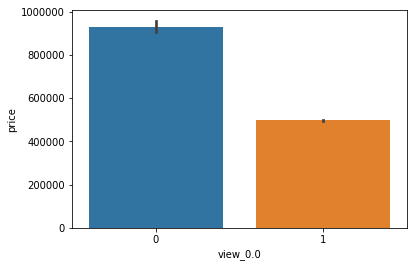

In [234]:
import seaborn as sns
sns.barplot(x='view_0.0', y='price', data=clean_house)

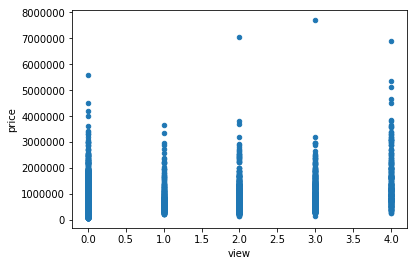

In [240]:
house.plot(x='view', y='price', kind='scatter')

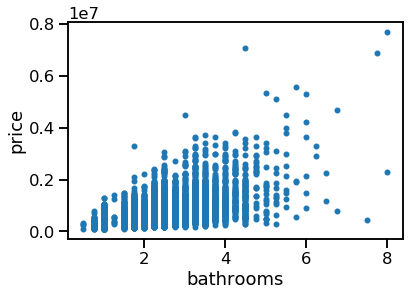

In [60]:
house.plot(x='bathrooms', y='price', kind='scatter')

AttributeError: Unknown property hue

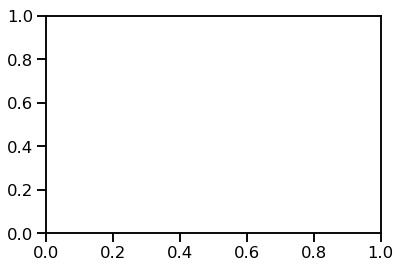

In [62]:
house.plot(x='lat', y='long', kind='scatter', hue='price')

ValueError: x and y must have same first dimension, but have shapes (16913,) and (171,)

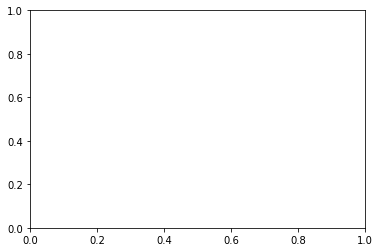

In [36]:
import matplotlib.pyplot as plt
plt.plot(range(len(X_train)), lasso.coef_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24f8d438>,
      dtype=object)

<Figure size 720x720 with 0 Axes>

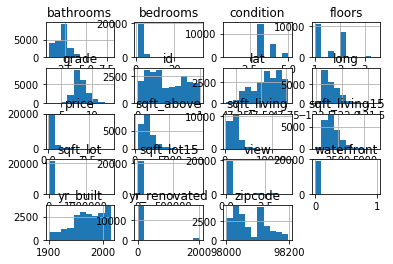

In [249]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
house.hist()

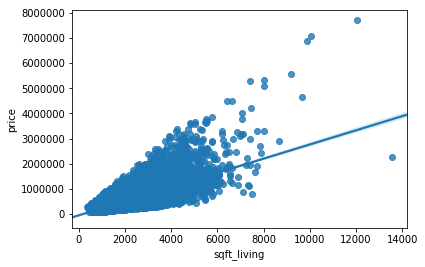

In [13]:
import seaborn as sns

sns.regplot(x="sqft_living",
                y="price",
                data=clean_house,)

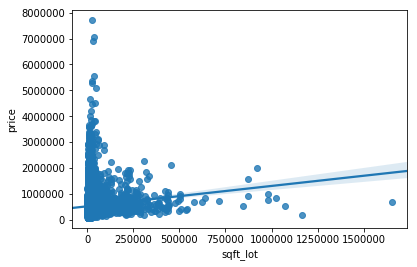

In [16]:
sns.regplot(y="price",
                x="sqft_lot",
                data=clean_house,)